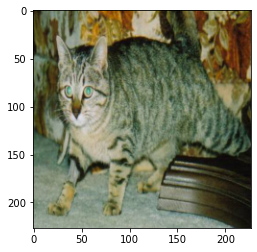

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 96, 111, 111])
torch.Size([96, 3, 7, 7])
torch.Size([1, 3, 225, 225])


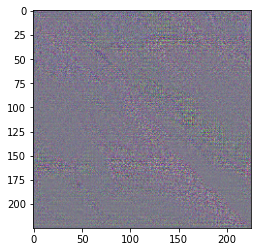

In [87]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(777)
torch.cuda.manual_seed_all(777)
#====================================================================
# calling data
trans = transforms.Compose([transforms.Resize((227,227)),
#                             transforms.RandomHorizontalFlip(p=0.5), #data augmentation
#                             transforms.RandomVerticalFlip(p=0.5),   #data augmentation
#                             transforms.RandomAffine(15),            #data augmentation
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.ImageFolder(root='/home/gus/catvsdog',
                                            transform=trans)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1,
                                          shuffle=True,
                                          drop_last=True,
                                          num_workers=2)
testset = torchvision.datasets.ImageFolder(root='/home/gus/cattest', 
                                           transform=trans)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=1,
                                         shuffle=True,
                                         drop_last=True,
                                         num_workers=2)
#====================================================================
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet,self).__init__()
        

        self.ft1 = torch.nn.Conv2d(3,96,7,stride=2,padding=1)
        self.ft2 = torch.nn.ReLU()
        self.ft3 = torch.nn.MaxPool2d(3,stride=2,padding=1,return_indices=True)
        self.ft4 = torch.nn.MaxUnpool2d(3,stride=2,padding=1)
        self.ft5 = torch.nn.ConvTranspose2d(96,3,7,stride=2,padding=1)
        
    def forward(self,x):
        out = self.ft1(x)
        W = self.ft1.weight
        out = self.ft2(out)
        out, indices = self.ft3(out)
        return out,W,indices

    
    def unpool(self,x,indices):
        out = self.ft4(x,indices)
        return out
    
    def Rect(self,x):
        out = self.ft2(x)
        return out
    
    def decon(self,x):
        out = self.ft5(x)
        return out
#====================================================================
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
#====================================================================
model = SimpleNet().to(device)
images = images.to(device)
pic = model(images)
a = model.unpool(pic[0],pic[2])
a = model.Rect(a)
print(a.shape)
print(pic[1].shape)
a = model.decon(a)
print(a.shape)
b = a.cpu().detach()
imshow(torchvision.utils.make_grid(b))